# Анализ данных в задаче кредитного скоринга

In [80]:
import numpy as np
import pandas as pd

import scipy
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл: 

     LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)
    SEX: пол клиента (1 = мужской, 2 = женский )
    EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
    MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
    AGE: возраст в годах
    PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
    BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
    PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 
    default - индикатор невозврата денежных средств








In [7]:
data = pd.read_csv('credit_card_default_analysis.csv', delimiter = ',', index_col = 'ID', header = 0)
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Задание 1 
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [40]:
repayment = data[data.default == 0]
loan = data[data.default == 1]

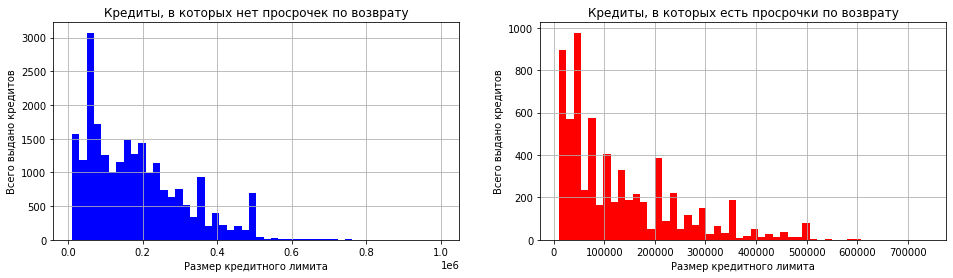

In [48]:
pylab.figure(figsize(16, 4))
pylab.subplot(1,2,1)
repayment['LIMIT_BAL'].hist(color='blue', bins = 50)
pylab.xlabel('Размер кредитного лимита')
pylab.ylabel('Всего выдано кредитов')
plt.title('Кредиты, в которых нет просрочек по возврату')


pylab.subplot(1,2,2)
loan['LIMIT_BAL'].hist(color='red', bins = 50)
pylab.xlabel('Размер кредитного лимита')
pylab.ylabel('Всего выдано кредитов')
plt.title('Кредиты, в которых есть просрочки по возврату')
plt.show()

Будем проверять гипотезу

$H_0$: медианы кредитов без просрочек и с просрочкой равны

$H_1$ : обратное

Построим 95% доверительный интервал для разности медиан и проверим, входит ли туда 0. Для этого используем метод бутстрепа.

In [49]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [50]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [51]:
np.random.seed(0)

repayment_limit_median_scores = list(map(np.median, get_bootstrap_samples(repayment.LIMIT_BAL.values, 1000)))
loan_limit_median_scores = list(map(np.median, get_bootstrap_samples(loan.LIMIT_BAL.values, 1000)))

In [55]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(loan_limit_median_scores,
                                                          repayment_limit_median_scores)))

In [56]:
print ("95% доверительный интервал для медианы кредитов без просрочек:",  stat_intervals(repayment_limit_median_scores, 0.05))
print("95% доверительный интервал для медианы просроченных кредитов:",  stat_intervals(loan_limit_median_scores, 0.05))
print("95% доверительный интервал для медианы разности",  stat_intervals(delta_median_scores, 0.05))

95% доверительный интервал для медианы кредитов без просрочек: [150000. 150000.]
95% доверительный интервал для медианы просроченных кредитов: [80000. 90000.]
95% доверительный интервал для медианы разности [60000. 70000.]


Выводы: медианы кредитных лимитов двух типов значимо отличаются. Медиана лимитов возвращенных кредитов в среднем на 65000 больше.

Проверим гипотезу о равенстве распределений с помощью перестановочного критерия для независимых выборок.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [57]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [58]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [59]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [60]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [61]:
print("p-value: %f" % permutation_test(repayment.LIMIT_BAL.values,
                                       loan.LIMIT_BAL.values, max_permutations = 10000))

p-value: 0.000100


Значение p-value меньше 0.05 - нулевая гипотеза отклоняется. Распределения кредитных лимитов по возвращенным и просроченным кредитам отличаются. Признак LIMIT_BAL значим (разные распределения и сильно разные медианы для двух типов кредитов)

### Задача 2: Пол (SEX)
Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

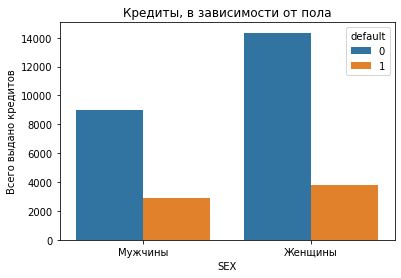

In [103]:
sns.countplot(x="SEX", hue="default", data=data)
plt.title('Кредиты, в зависимости от пола')
plt.xticks([0, 1],('Мужчины', 'Женщины'))
plt.ylabel('Всего выдано кредитов')
plt.show()

Женщинам выдают существенно больше кредитов. Доля возвращенных кредитов (синяя колонка) примерно одинаковы для каждого пола.

Проверим так ли это.

$H_0: \;p_{man} = p_{woman}$ - доли равны

$H_1$: обратное

Для этого воспользуемся Z-критерием для разности долей в независимых выборках.

In [81]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [82]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [83]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [98]:
print('95%% доверительный интервал разницы долей между мужчинами и женщинами: [%f, %f]'
      %proportions_diff_confint_ind(data[data.SEX == 1].default, data[data.SEX == 2].default))

95% доверительный интервал разницы долей между мужчинами и женщинами: [0.024207, 0.043612]


In [89]:
print("p-value: %.e" % proportions_diff_z_test(proportions_diff_z_stat_ind(data[data.SEX == 1].default, data[data.SEX == 2].default)))

p-value: 4e-12


Вывод: доли (кредит без просрочек/кредит с просрочками) между мужчинами и женщинами статистически различаются (p-value < 0.05). Судить о практической значимости довольно тяжело: с одной стороны, разница от 2,4% до 4,3% кажется маленькой, незначительной, но с другой стороны, банк на этом может потерять много денег.

### Задание 3: Образование (EDUCATION)
Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборот, не отдаст долг ?

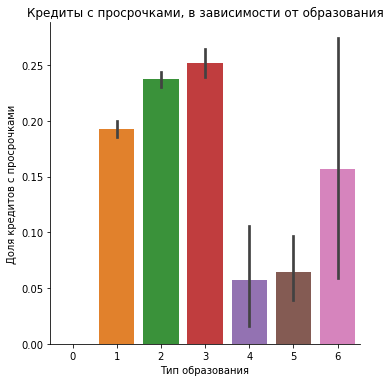

In [107]:
sns.catplot(x='EDUCATION', y='default',  data=data, kind = 'bar')
plt.ylabel('Доля кредитов с просрочками')
plt.xlabel('Тип образования')
plt.title('Кредиты с просрочками, в зависимости от образования')
plt.show()

образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных )

Интересно, что у докторов наук вообще нет просроченных кредитов, и малая доля просрочек у респондентов с начальным образованием и прочим. 



Проверим, зависимы ли тип образования и наличие/отсутствие просрочек в оплате кредита (есть ли корреляция). Для этого воспользуемся критерием хи-квадрат. Нулевая гипотеза $H_0$: подвыборки образования заемщиков вернувших и не вернувших кредит -- независимы, альтернативная $H_1$: нулевая гипотеза неверна.
Предварительно составим таблицу сопряженности для образования и возврата / не возврата кредита:


In [108]:
df_educ_default = pd.DataFrame({'Без просрочек': data[data['default'] == 0].EDUCATION.value_counts(),
                                'С просрочками': data[data['default'] == 1].EDUCATION.value_counts()})
df_educ_default.iloc[0,1] = 0
df_educ_default

,Без просрочек,С просрочками
0,14,0.0
1,8549,2036.0
2,10700,3330.0
3,3680,1237.0
4,116,7.0
5,262,18.0
6,43,8.0


Построив таблицу, мы видим, что данные не очень сбалансированы (всего 14 данных респондентов с научной степенью, и и десятки-сотни с категориями 4-5-6). Большая часть данных о людях с высшим образованием (бакалавриат или магистратура).  

In [121]:
def cramer(chi, n, shape):
    return np.sqrt(chi/n/(min(shape[0], shape[1])-1))

n = len(data) 
print("p-value: ", stats.chi2_contingency(df_educ_default)[1])
print('v-cramer: ', cramer(stats.chi2_contingency(df_educ_default)[0],
                             n, df_educ_default.shape))

p-value:  1.2332626245415605e-32
v-cramer:  0.07376009713252163


Интересно, что гипотеза о независимости образования и наличия/отсутствия просрочек в оплате кредита отвергается на основании критерия $\chi^2$ отвергается. Но при этом коэффициент крамера для сводной таблицы оказывается не очень большим (всего 0.07), что говорит о том, что взаимосвязь слабая.

Результат имеет практическую значимость для выдачи кредита, доли возврата значимо отличаются для разных уровней образования.

### Задание 4: Семейное положение (MARRIAGE)
Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

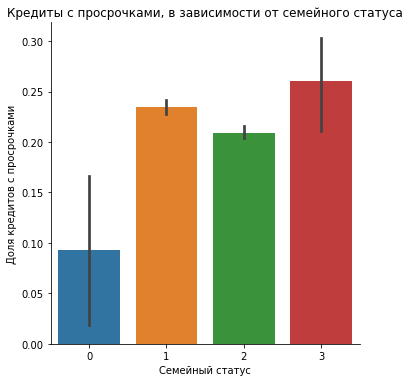

In [116]:
sns.catplot(x='MARRIAGE', y='default',  data=data, kind = 'bar')
plt.ylabel('Доля кредитов с просрочками')
plt.xlabel('Семейный статус')
plt.title('Кредиты с просрочками, в зависимости от семейного статуса')
plt.show()

0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных

Почти у всех типов примерно одинаковая доля просроченных кредитов. Малая доля просрочек кредитов людей, которые отказались отвечать, может быть связана с малой статистикой этой категории

In [117]:
df_marr_default = pd.DataFrame({'Без просрочек': data[data['default'] == 0].MARRIAGE.value_counts(),
                                'С просрочками': data[data['default'] == 1].MARRIAGE.value_counts()})
df_marr_default

,Без просрочек,С просрочками
2,12623,3341
1,10453,3206
3,239,84
0,49,5


Действительно наше предположение о малой статистике отказавшихся отвечать подтвердилось 

In [120]:
print('p-value: ', stats.chi2_contingency(df_marr_default)[1])
print('v_cramer: ', cramer(stats.chi2_contingency(df_marr_default)[0],
                             n, df_marr_default.shape))

p-value:  8.825862457577375e-08
v_cramer:  0.034478203662766466


Аналогичный случай с образованием: p-value очень мало (гипотеза о независимости отвергается), но коэффициент крамера тоже мал (очень слабая взаимосвязь). Практическая значимость состоит в том, что неважно с каким семейным статусом приходит человек за кредитом.

### Задание 5: Возраст (AGE)
Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

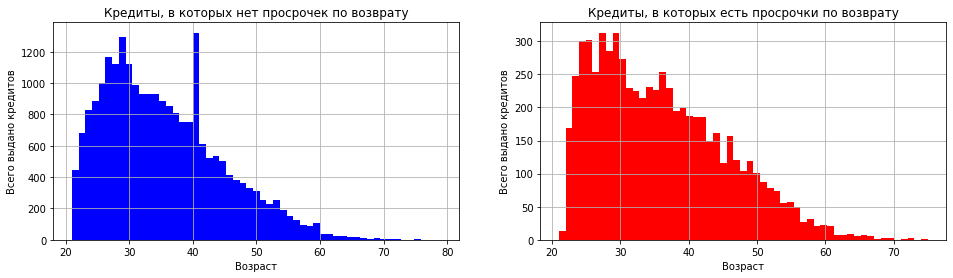

In [124]:
pylab.figure(figsize(16, 4))
pylab.subplot(1,2,1)
repayment['AGE'].hist(color='blue', bins = 55)
pylab.xlabel('Возраст')
pylab.ylabel('Всего выдано кредитов')
plt.title('Кредиты, в которых нет просрочек по возврату')


pylab.subplot(1,2,2)
loan['AGE'].hist(color='red', bins = 55)
pylab.xlabel('Возраст')
pylab.ylabel('Всего выдано кредитов')
plt.title('Кредиты, в которых есть просрочки по возврату')
plt.show()

Как можно заметить распредления почти одинаковы.

Проверим сначала гипотезу о равенстве медианных значений.

$H_0$: медианы кредитов без просрочек и с просрочкой равны

$H_1$ : обратное

Построим 95% доверительный интервал для разности медиан и проверим, входит ли туда 0. Для этого используем метод бутстрепа.

In [125]:
np.random.seed(123)

repayment_age_median_scores = list(map(np.median, get_bootstrap_samples(repayment.AGE.values, 1000)))
loan_age_median_scores = list(map(np.median, get_bootstrap_samples(loan.AGE.values, 1000)))

In [126]:
delta_age_median_scores = list(map(lambda x: x[1] - x[0], zip(loan_age_median_scores,
                                                          repayment_age_median_scores)))

In [127]:
print ("95% доверительный интервал для медианы кредитов без просрочек:",  stat_intervals(repayment_age_median_scores, 0.05))
print("95% доверительный интервал для медианы просроченных кредитов:",  stat_intervals(loan_age_median_scores, 0.05))
print("95% доверительный интервал для медианы разности",  stat_intervals(delta_age_median_scores, 0.05))

95% доверительный интервал для медианы кредитов без просрочек: [34. 34.]
95% доверительный интервал для медианы просроченных кредитов: [34. 35.]
95% доверительный интервал для медианы разности [-1.  0.]


0 входит в 95% доверит. интервал, а значит нельзя нулевая гипотеза не отклоняется.

Проверим теперь равны ли распределения с помощью перестановочного критерия для независимых выборок.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [129]:
print("p-value: %f" % permutation_test(repayment.AGE.values,
                                       loan.AGE.values, max_permutations = 1000))

p-value: 0.017000


Распределения не одинаковы.

Результат является практически значимым.